# Intepretation of Random Forest Models For Enhancer Activity Prediction

**Authorship:**
Adam Klie, *09/26/2021*
***
**Description:**
Notebook for the interpretation of random forest model predictions
***
**TODOs:**
 - <font color='green'> Done TODO </font>
 - <font color='orange'> WIP TODO </font>
 - <font color='red'> Queued TODO </font>
***

In [1]:
# Classics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Loading webpages
from scipy import stats
from IPython.display import IFrame
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pickle

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

In [2]:
import sys
sys.path.append('/cellar/users/aklie/projects/EUGENE/bin/')
import project_utils

# Define parameters of the notebook

In [3]:
DATASET = "2021-OLS-Library"  # Which dataset to look at
FEATURES = "mixed-1.0"  # What features to use to train the model
PREPROCESS = "0.18-0.4"  # Preprocessing steps, separated by "-"
HYPERPARAM = "100-trials-hyperopt"

# Load data

In [4]:
X = np.loadtxt('../data/{0}/{1}/X_{2}_{3}.txt'.format(DATASET.replace("-", "_"), FEATURES.replace("-", "_"), FEATURES, PREPROCESS), dtype=float)

In [5]:
y = np.loadtxt('../data/{0}/y_binary_{1}.txt'.format(DATASET.replace("-", "_"), PREPROCESS), dtype=int)
IDs = np.loadtxt('../data/{0}/sequence_id_{1}.txt'.format(DATASET.replace("-", "_"), PREPROCESS), dtype=str)
dataframe = pd.read_csv("../data/{0}/20210728-3.EnhancerTable.ForAdam.FunctionalEnhancers.WT-detected.ABL-notDetected.10R-20U-0.1P.tsv".format(DATASET.replace("-", "_")), sep="\t", na_values="na")
IDs[0], X[0], y[0], IDs.shape, X.shape, y.shape

('S1-G1R-S2-E1F-S3-E2F-S4-G2R-S5-G3F-S6',
 array([12. ,  0. ,  0. ,  0.9,  2. ,  1. ,  1. ,  0.6,  7. ,  1. ,  1. ,
         0.4,  5. ,  0. ,  0. ,  0.3,  0. ,  0. ,  1. ,  0.5,  1. ]),
 1,
 (302936,),
 (302936, 21),
 (302936,))

In [6]:
dataframe = dataframe[~dataframe["MPRA_FXN"].isna()].set_index("NAME")
dataframe.head(1)

,SEQUENCE,MPRA_FXN,MICROSCOPE_FXN,ACTIVITY_SUMRNA_NUMDNA
NAME,,,,
S1-G1R-S2-E1F-S3-E2F-S4-G2R-S5-G3F-S6,CATCTGAAGCTCGTTATCTCTAACGGAAGTTTTCGAAAAGGAAATT...,1.0,Neural Enhancer,0.611767


# Get the test set

## **Train/test split**

In [7]:
X_train, X_test, y_train, y_test, IDs_train, IDs_test = train_test_split(X, y, IDs, train_size=0.9, random_state=13)
X_train.shape, X_test.shape, y_train.shape, y_test.shape, IDs_train.shape, IDs_test.shape

((272642, 21), (30294, 21), (272642,), (30294,), (272642,), (30294,))

In [8]:
np.unique(y_train, return_counts=True)[1]/len(y_train), np.unique(y_test, return_counts=True)[1]/len(y_test)

(array([0.68878236, 0.31121764]), array([0.69115997, 0.30884003]))

In [9]:
file = "../data/{0}/{1}/{2}_header.txt".format(DATASET.replace("-", "_"), FEATURES.replace("-", "_"), FEATURES)
with open(file, "r") as f:
    features = [line.rstrip() for line in f.readlines()]

In [10]:
train_df = pd.DataFrame(X_train, columns=features, index=IDs_train)
train_df = pd.merge(dataframe, train_df, left_index=True, right_index=True)

In [11]:
test_df = pd.DataFrame(X_test, columns=features, index=IDs_test)
test_df = pd.merge(dataframe, test_df, left_index=True, right_index=True)

## **Standardize features**: *For mixed encoding only*

In [12]:
if FEATURES in ["block", "ohe-seq"]:
    scale_indeces = []  # Block and one-hot
elif FEATURES in ["mixed-1.0"]:
    scale_indeces = np.array([0, 3, 4, 7, 8, 11, 12, 15, 16, 19, 20])  # Mixed 1.0
elif FEATURES in ["mixed-2.0"]:   
    scale_indeces = np.array([0, 5, 10, 15, 20, 25])  # Mixed 2.0

In [13]:
X_scaled_train, X_scaled_test = project_utils.standardize_features(train_X=X_train, test_X=X_test, indeces=scale_indeces)
X_train[:, scale_indeces].mean(axis=0), X_train[:, scale_indeces].std(axis=0)

(array([ 4.95166261e-18,  5.08666057e-16, -5.46246570e-17, -9.37870960e-16,
        -2.41979933e-17, -4.33452908e-16, -1.22879417e-16,  3.65015719e-16,
         1.01274531e-16,  7.06367702e-16,  9.42379579e-17]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))

# Load previously trained model

In [14]:
file = '{}_{}_RF-clf_{}.pickle'.format(PREPROCESS, FEATURES, HYPERPARAM)
clf = pickle.load(open(file, 'rb'))

In [15]:
y_tr_preds = clf.predict(X_train)
y_preds = clf.predict(X_test)

In [16]:
y_tr_probs = clf.predict_proba(X_train)[:, 1]
y_probs = clf.predict_proba(X_test)[:, 1]

# Analysis of missed predictions

### <u>**Confusion matrices** </u>

In [17]:
from sklearn.metrics import confusion_matrix

In [18]:
np.unique(y_tr_preds, return_counts=True), np.unique(y_preds, return_counts=True)

((array([0, 1]), array([229313,  43329])),
 (array([0, 1]), array([26169,  4125])))

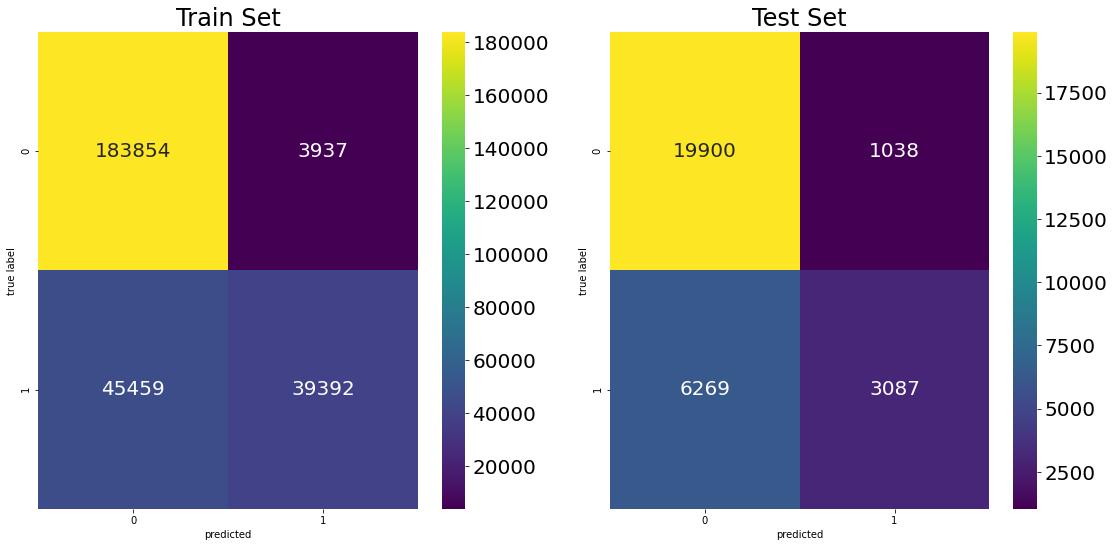

In [19]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
rc = {"font.size" : 20}
with plt.rc_context(rc):
    sns.heatmap(confusion_matrix(y_train, y_tr_preds), annot=True, fmt='d', cmap='viridis', ax=ax[0])
    ax[0].set_xlabel('predicted')
    ax[0].set_ylabel('true label')
    ax[0].set_title('Train Set')

    sns.heatmap(confusion_matrix(y_test, y_preds), annot=True, fmt='d', cmap='viridis', ax=ax[1])
    ax[1].set_xlabel('predicted')
    ax[1].set_ylabel('true label')
    ax[1].set_title('Test Set')

    fig.tight_layout();

#### Train

In [20]:
clf_train_df = pd.DataFrame(index=IDs_train, data={"labels": y_train, "preds":y_tr_preds, "probability":y_tr_probs})
clf_train_df.index.name = "NAME"
train_df = pd.merge(train_df, clf_train_df, left_index=True, right_index=True)
train_df["classification"] = ["-".join(list(value)) for value in train_df[["labels", "preds"]].values.astype(str)]
train_df["classification"] = train_df["classification"].replace({"0-0": "TN", "1-0": "FN", "0-1": "FP", "1-1": "TP"})
train_df["classification"].value_counts()
train_df["ACTIVITY_SUMRNA_NUMDNA"].replace(np.inf, np.nan, inplace=True)
train_df = train_df[np.abs(stats.zscore(train_df["ACTIVITY_SUMRNA_NUMDNA"], nan_policy="omit")) < 3]

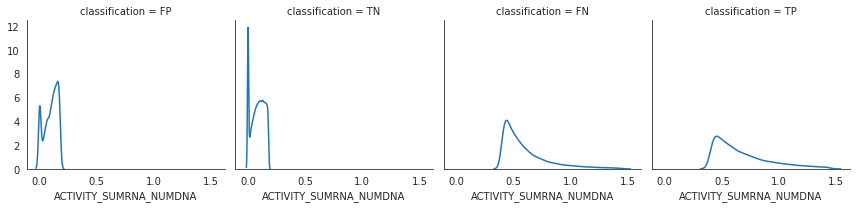

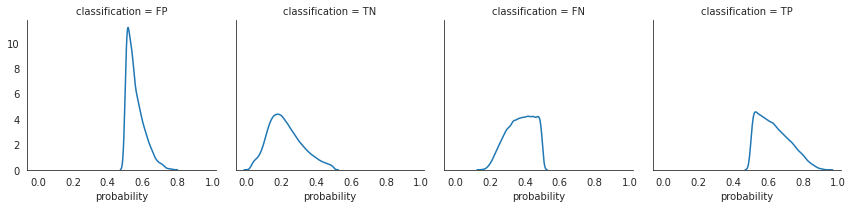

In [21]:
sns.set_style("white")
g = sns.FacetGrid(train_df, col="classification", col_order=["FP", "TN", "FN", "TP"])
g.map(sns.kdeplot, "ACTIVITY_SUMRNA_NUMDNA")
g2 = sns.FacetGrid(train_df, col="classification", col_order=["FP", "TN", "FN", "TP"])
g2.map(sns.kdeplot, "probability")

#### Test

In [22]:
clf_test_df = pd.DataFrame(index=IDs_test, data={"labels": y_test, "preds":y_preds, "probability":y_probs})
clf_test_df.index.name = "NAME"
test_df = pd.merge(test_df, clf_test_df, left_index=True, right_index=True)
test_df["classification"] = ["-".join(list(value)) for value in test_df[["labels", "preds"]].values.astype(str)]
test_df["classification"] = test_df["classification"].replace({"0-0": "TN", "1-0": "FN", "0-1": "FP", "1-1": "TP"})
test_df["classification"].value_counts()
test_df["ACTIVITY_SUMRNA_NUMDNA"].replace(np.inf, np.nan, inplace=True)
test_df = test_df[np.abs(stats.zscore(test_df["ACTIVITY_SUMRNA_NUMDNA"], nan_policy="omit")) < 3]

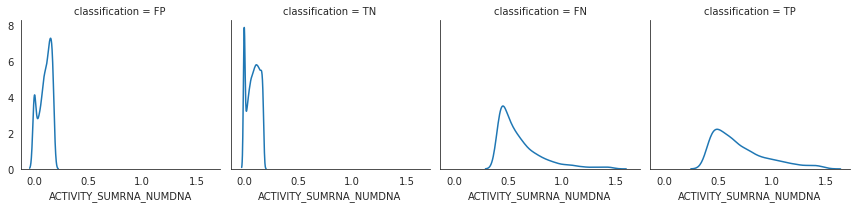

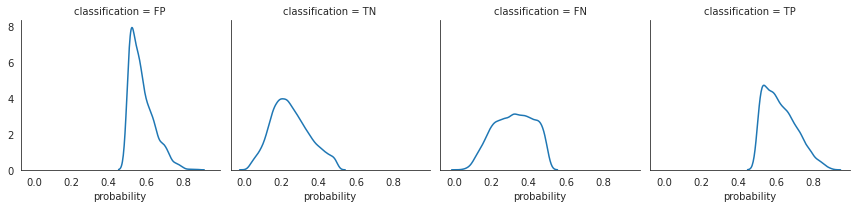

In [23]:
sns.set_style("white")
g = sns.FacetGrid(test_df, col="classification", col_order=["FP", "TN", "FN", "TP"])
g.map(sns.kdeplot, "ACTIVITY_SUMRNA_NUMDNA")
g2 = sns.FacetGrid(test_df, col="classification", col_order=["FP", "TN", "FN", "TP"])
g2.map(sns.kdeplot, "probability")

<AxesSubplot:xlabel='probability', ylabel='Count'>

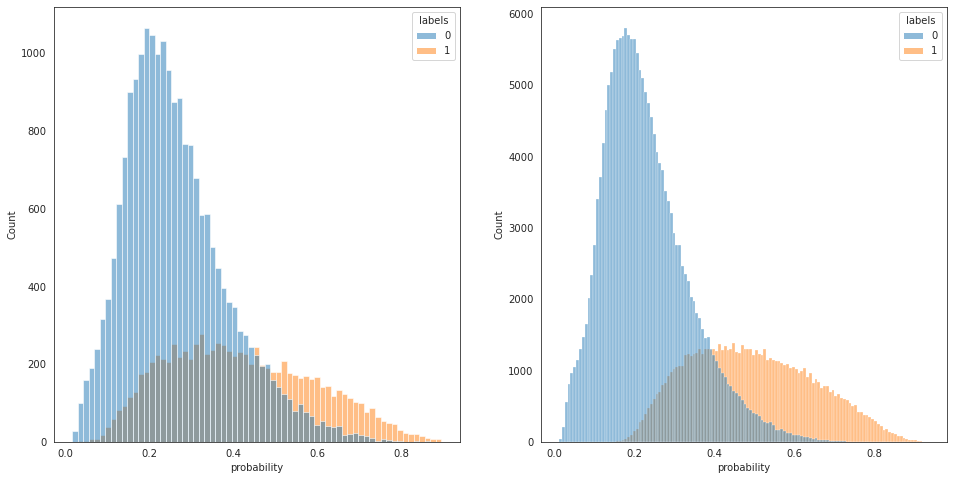

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(16,8))
sns.histplot(data=train_df, x="probability", hue="labels", ax=ax[1]);
sns.histplot(data=test_df, x="probability", hue="labels", ax=ax[0])

<ipython-input-180-1cfaf05eeda8>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(16,8))


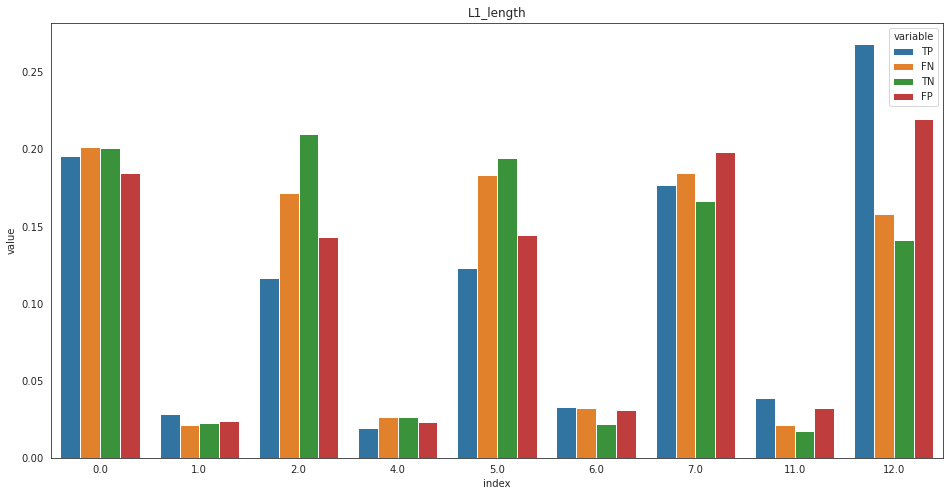

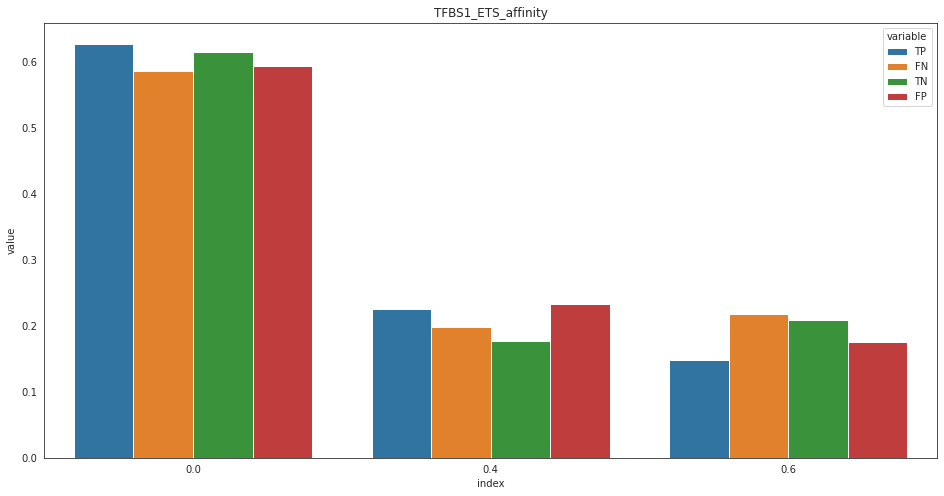

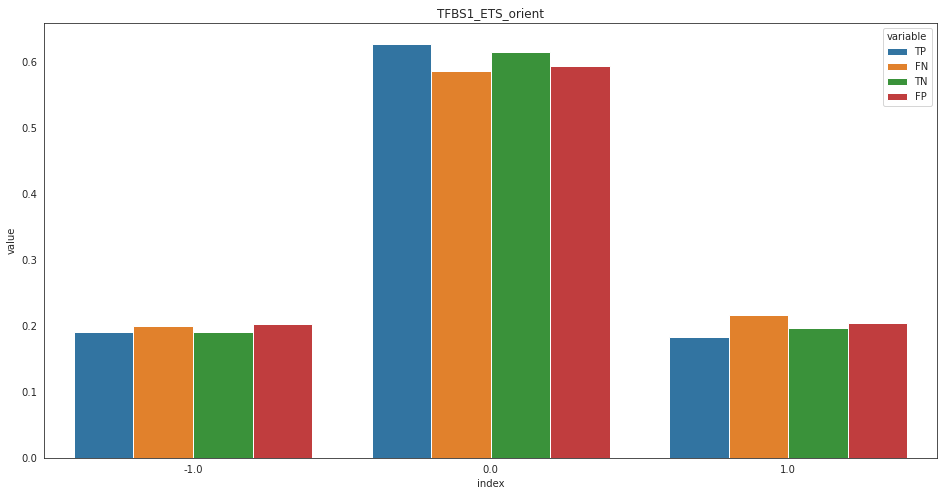

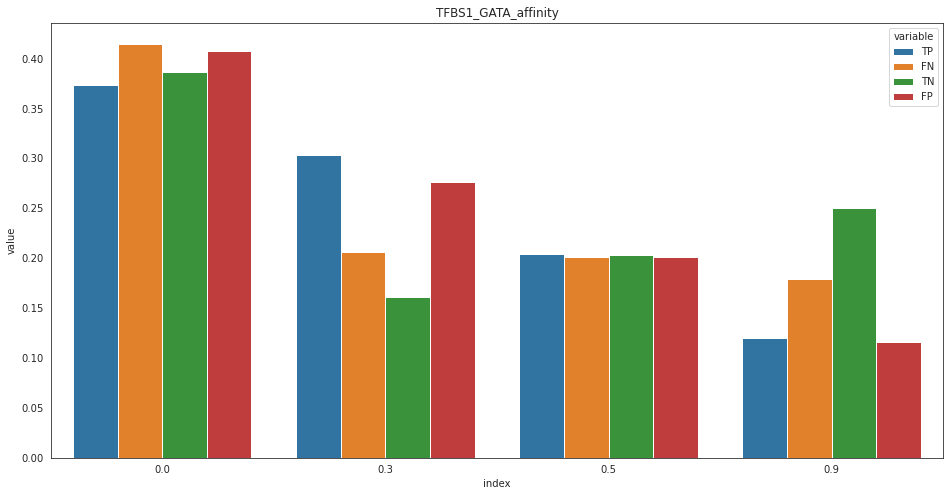

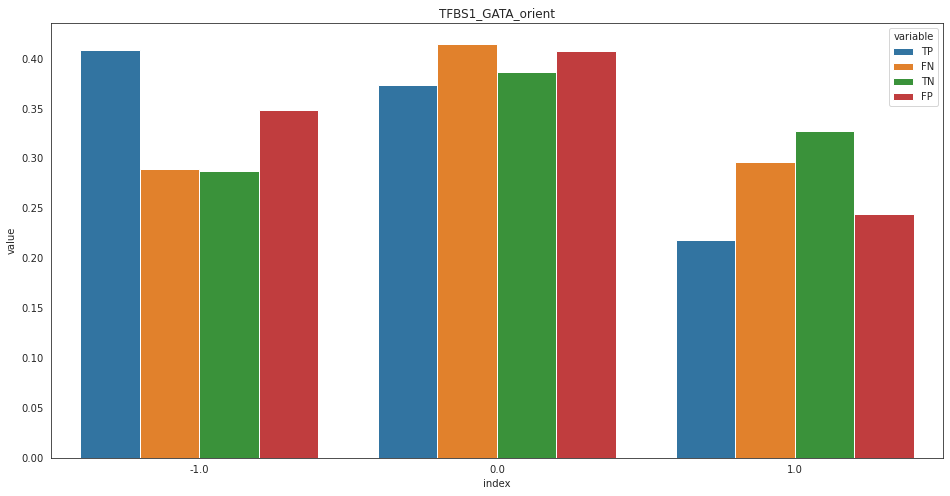

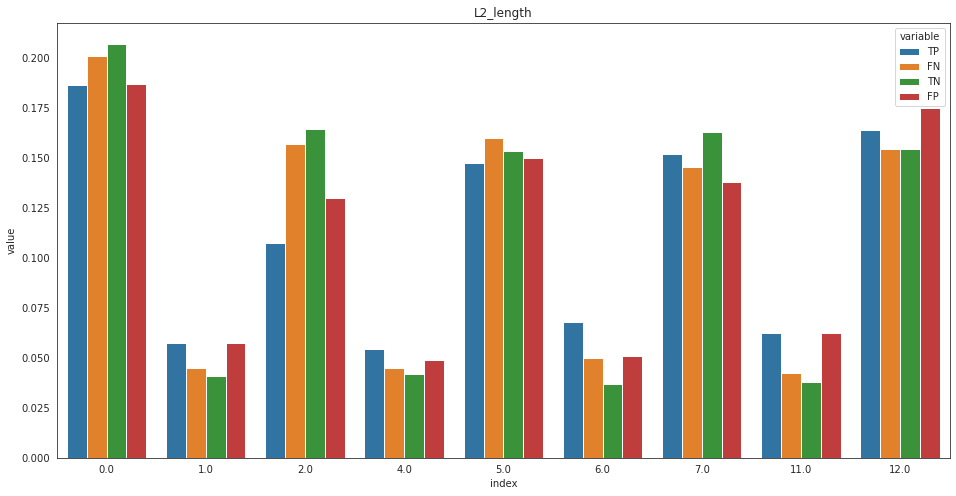

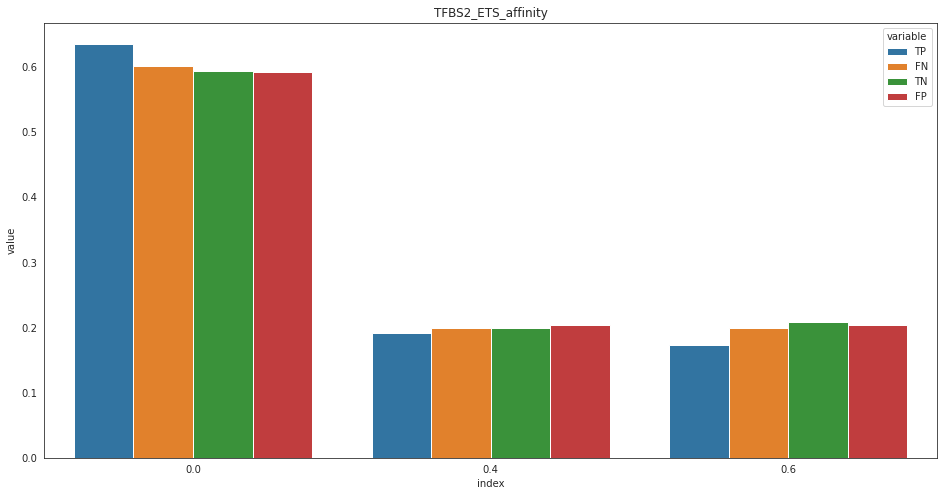

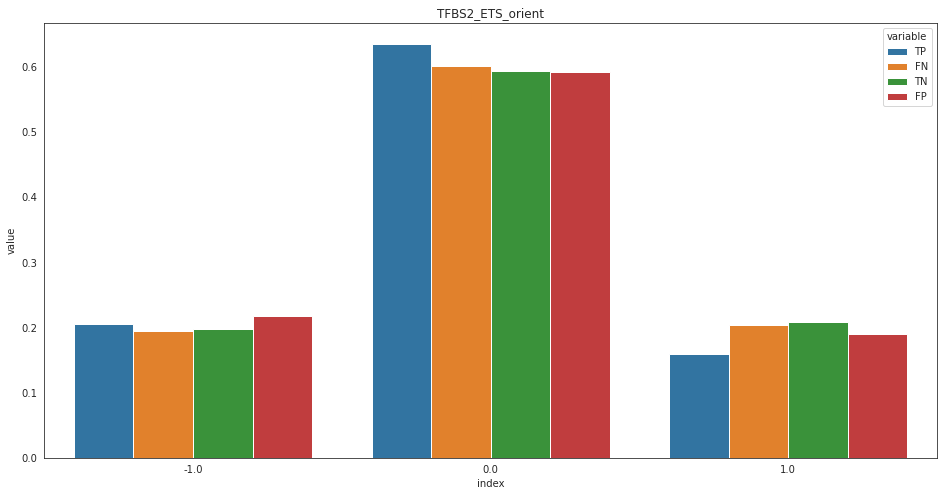

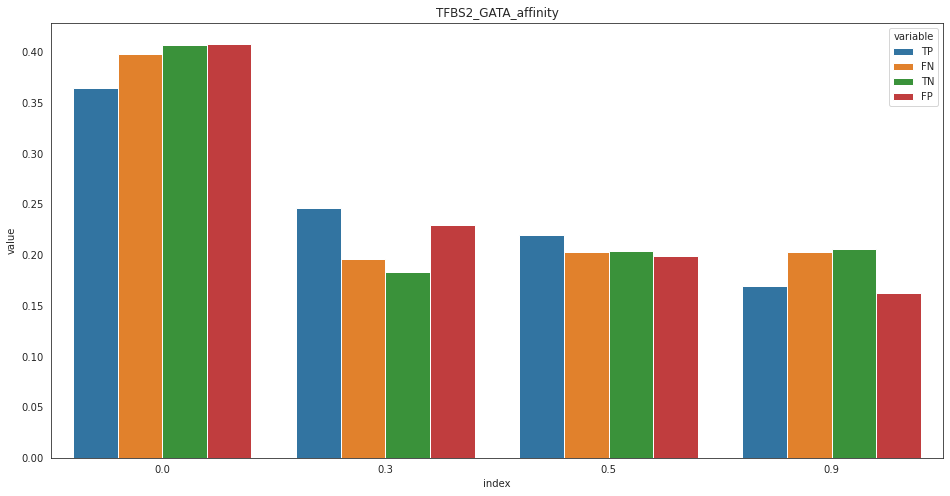

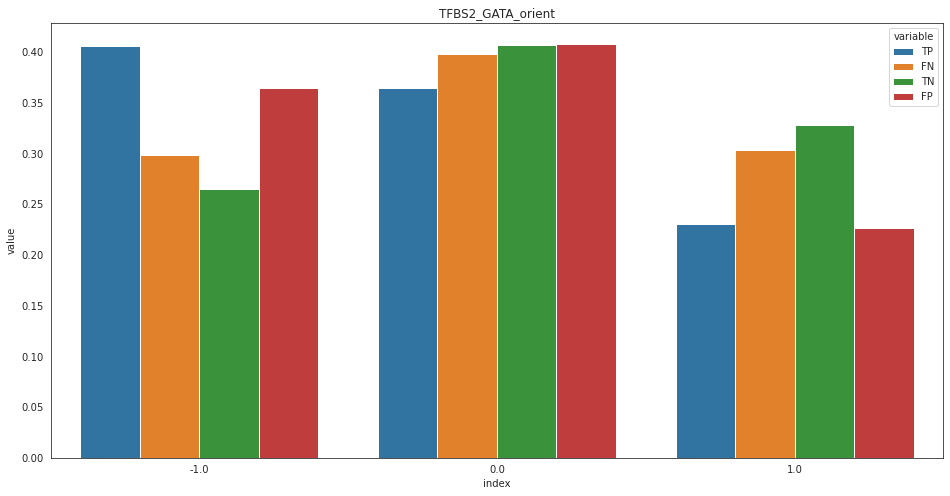

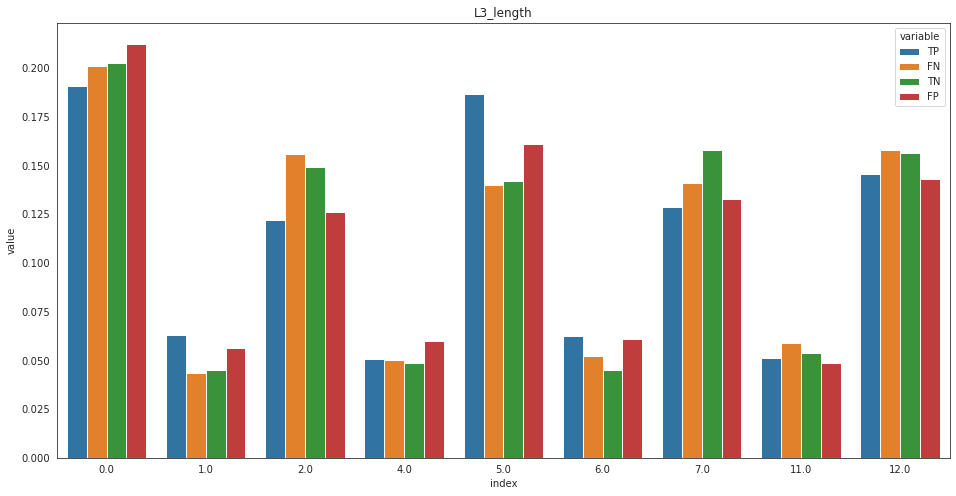

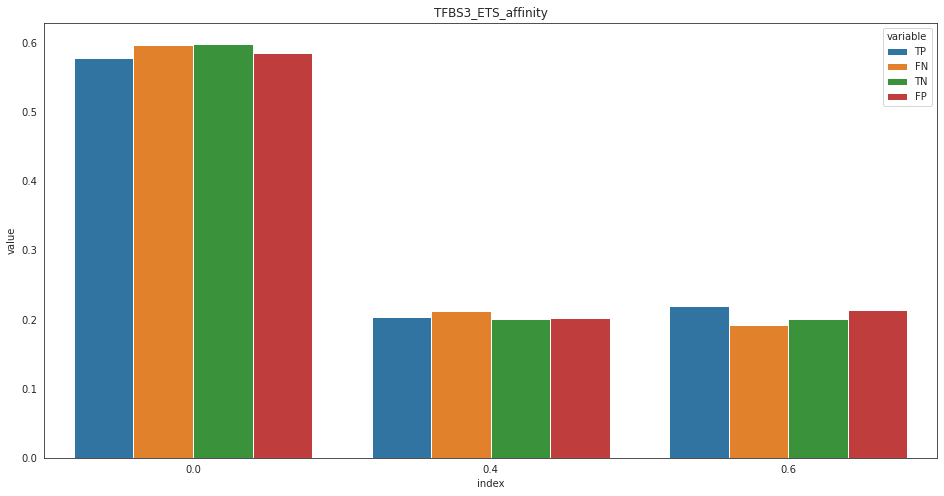

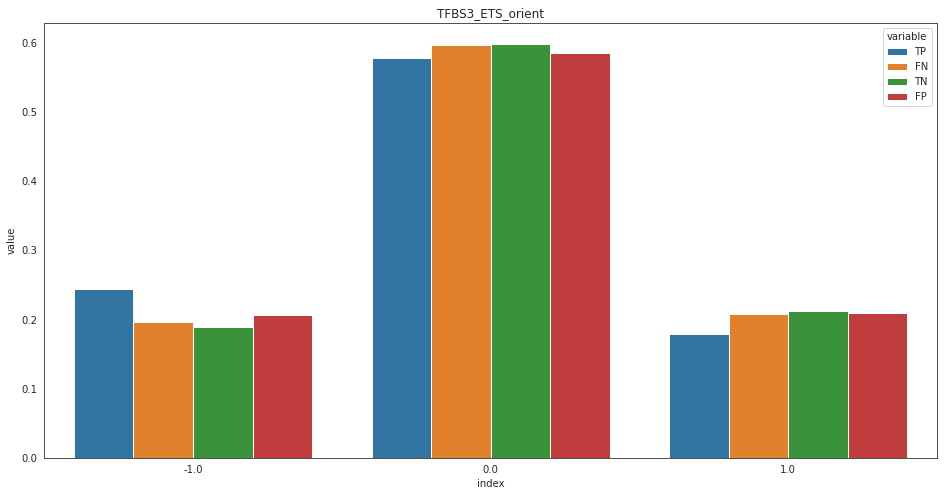

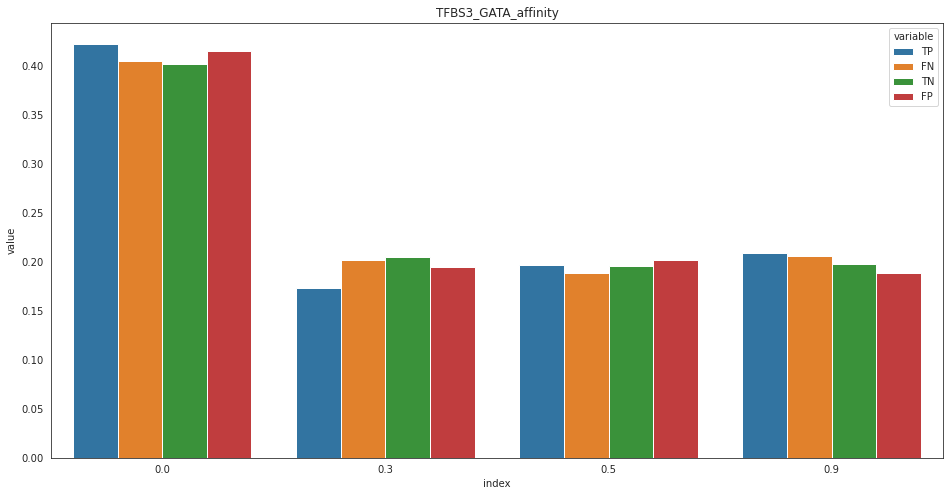

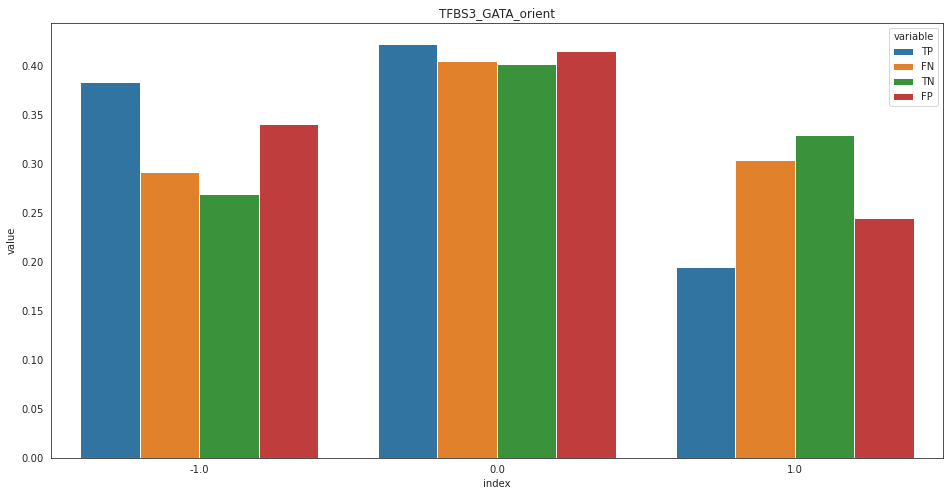

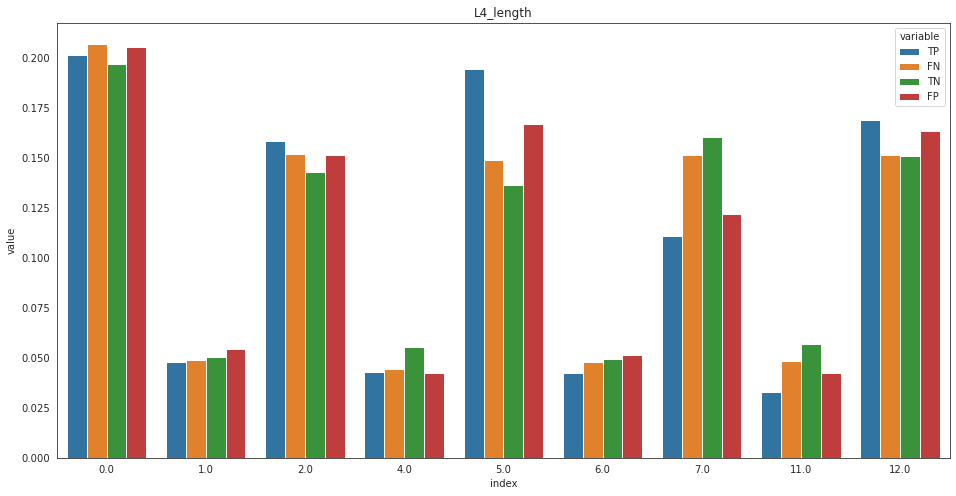

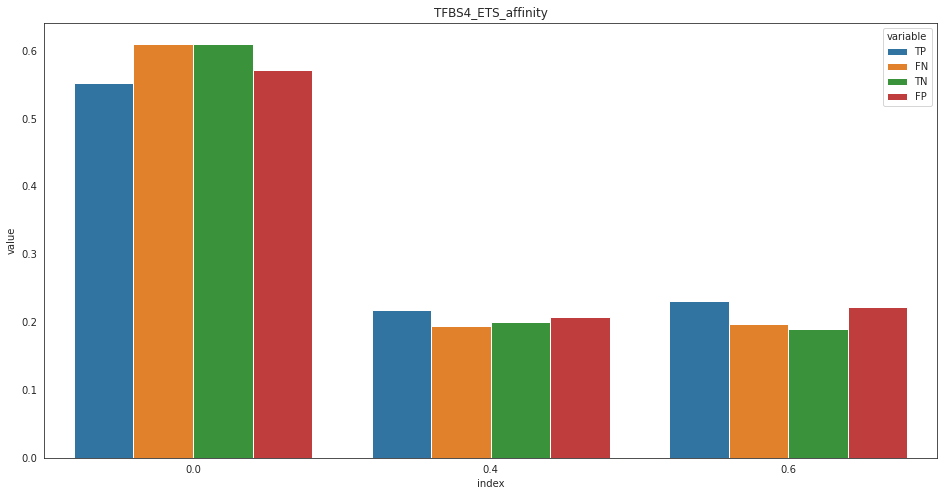

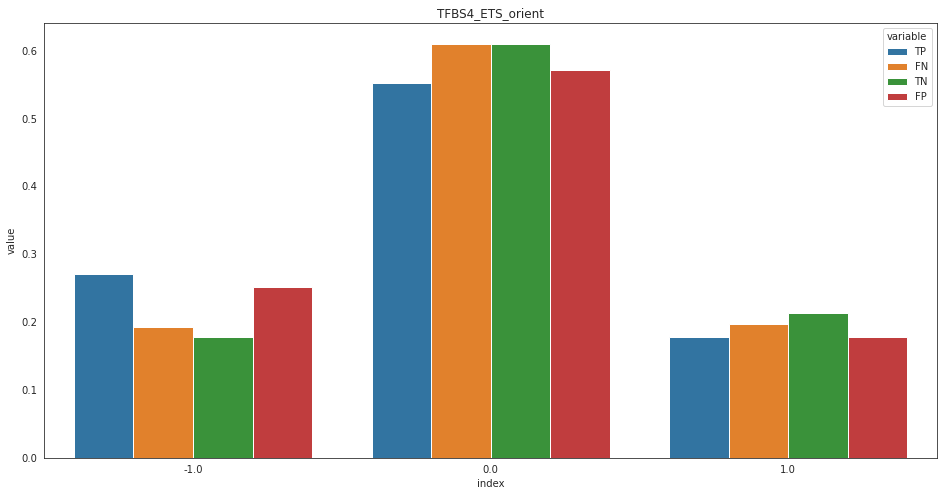

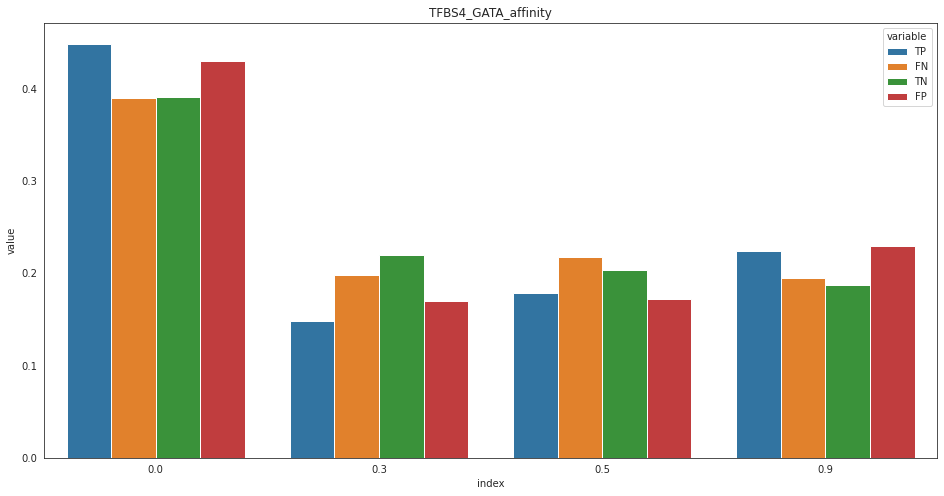

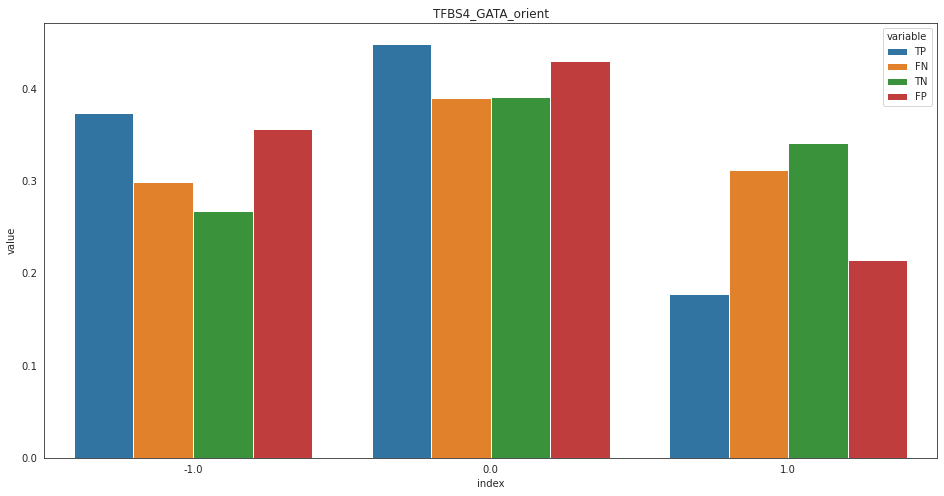

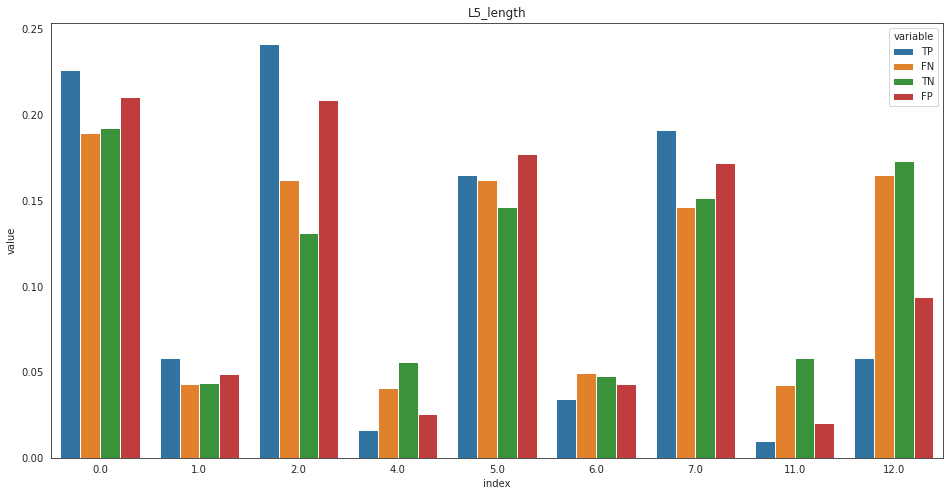

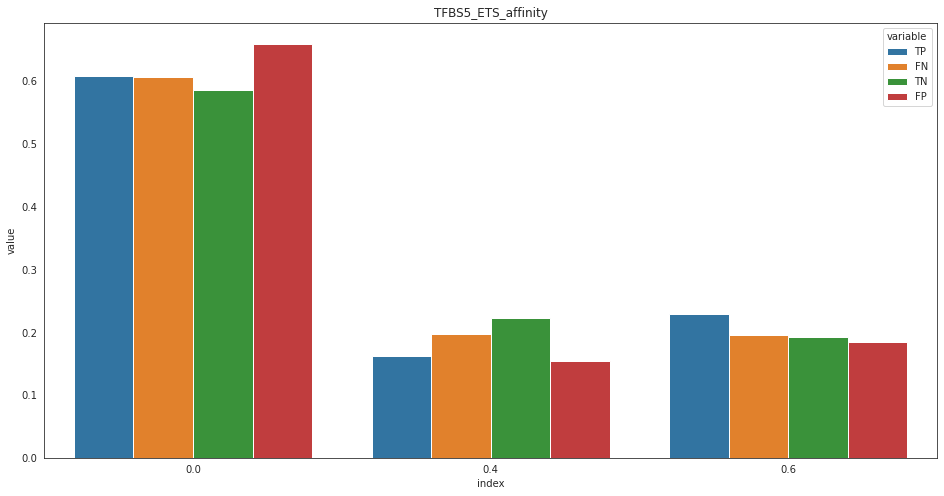

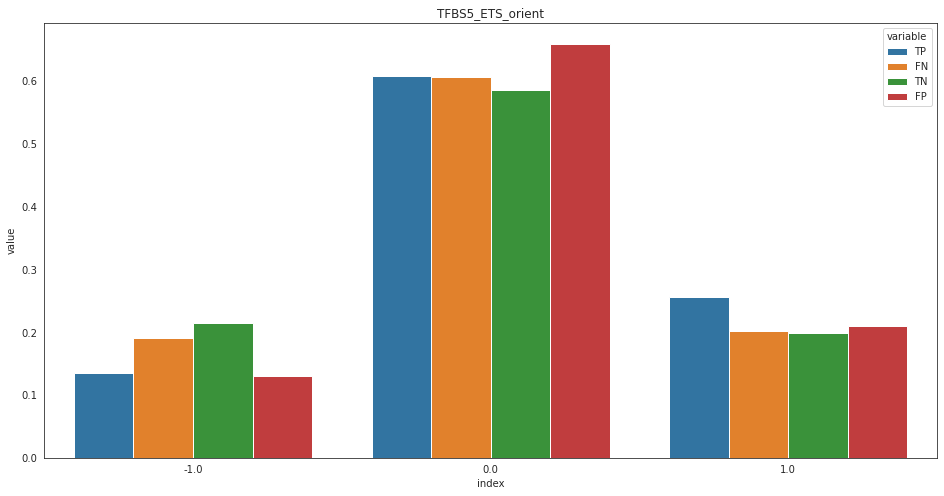

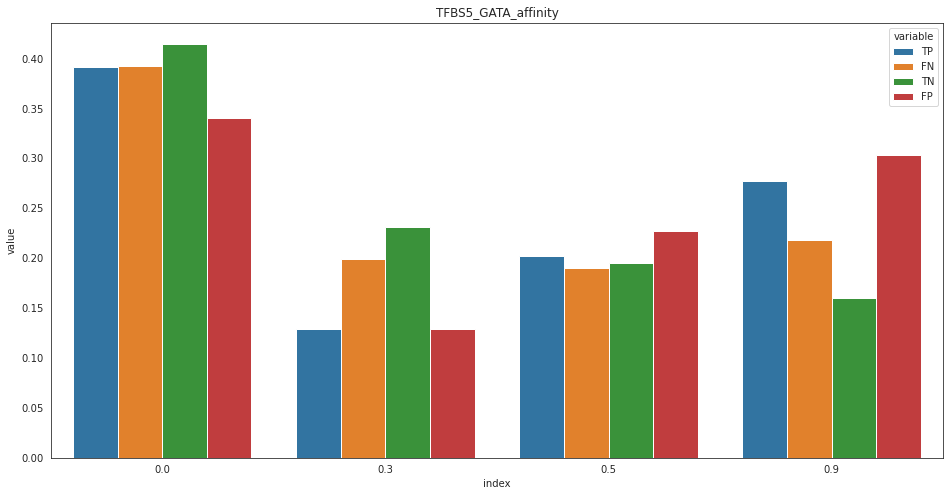

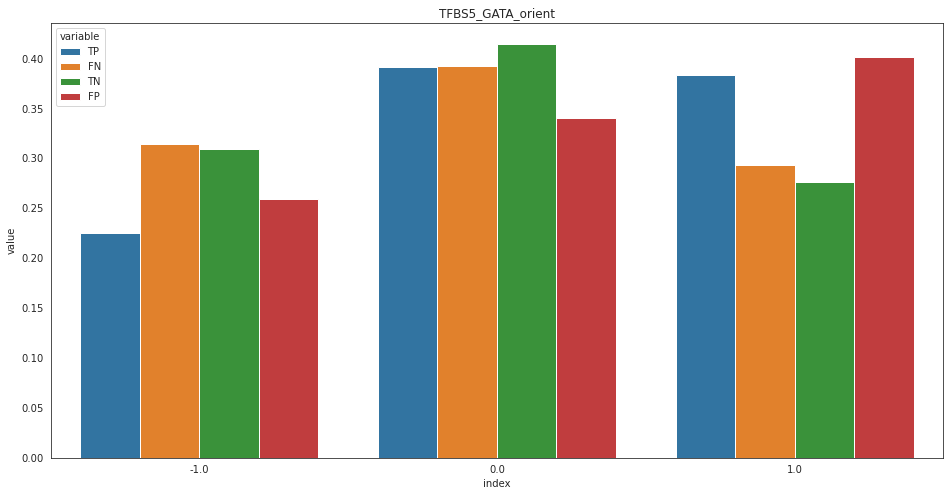

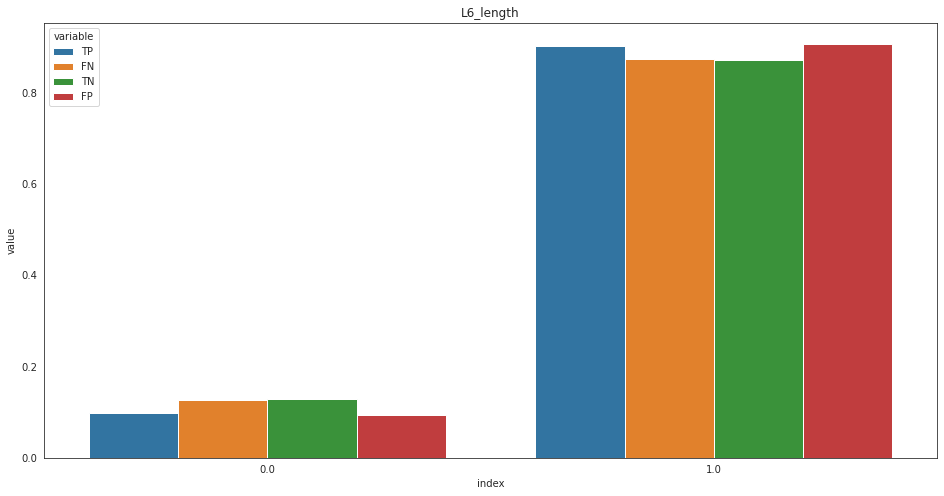

In [180]:
for col in test_df[features]:
    tp_perc = test_df[test_df["classification"] == "TP"][col].value_counts(normalize=True)
    fn_perc = test_df[test_df["classification"] == "FN"][col].value_counts(normalize=True)
    tn_perc = test_df[test_df["classification"] == "TN"][col].value_counts(normalize=True)
    fp_perc = test_df[test_df["classification"] == "FP"][col].value_counts(normalize=True)
    perc = pd.concat([tp_perc, fn_perc, tn_perc, fp_perc], axis=1)
    perc.columns = ["TP", "FN", "TN", "FP"]
    data = perc.melt(ignore_index=False).reset_index()

    fig, ax = plt.subplots(figsize=(16,8))
    sns.barplot(data=data, x="index", y="value", hue="variable", ax=ax)
    ax.set_title(col)

## Feature Importance Anaysis

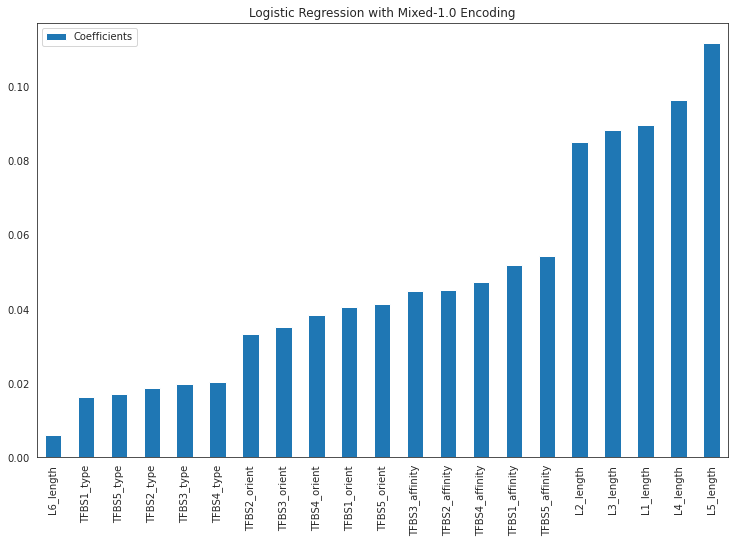

In [26]:
coefs = pd.DataFrame(
    clf.feature_importances_,
    columns=["Coefficients"],
    index=features,
)
coefs = coefs.sort_values("Coefficients", ascending=True)
coefs.plot(kind="bar", figsize=(16, 8))
plt.title("Logistic Regression with Mixed-1.0 Encoding")
#plt.axhline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

# Scratch

In [82]:
test_df = pd.DataFrame(X_test, columns=mixed1, index=IDs_test)
test_df = pd.merge(dataframe, test_df, left_index=True, right_index=True)

In [84]:
clf_test_df = pd.DataFrame(index=IDs_test, data={"labels": y_test, "preds":y_preds, "probability":y_probs})
clf_test_df.index.name = "NAME"

In [85]:
test_df = pd.merge(test_df, clf_test_df, left_index=True, right_index=True)

test_df["classification"] = ["-".join(list(value)) for value in test_df[["labels", "preds"]].values.astype(str)]
test_df["classification"] = test_df["classification"].replace({"0-0": "TN", "1-0": "FN", "0-1": "FP", "1-1": "TP"})

test_df["classification"].value_counts()

test_df[np.isinf(test_df["ACTIVITY_SUMRNA_NUMDNA"])]

test_df["ACTIVITY_SUMRNA_NUMDNA"].clip(0, 1, inplace=True)

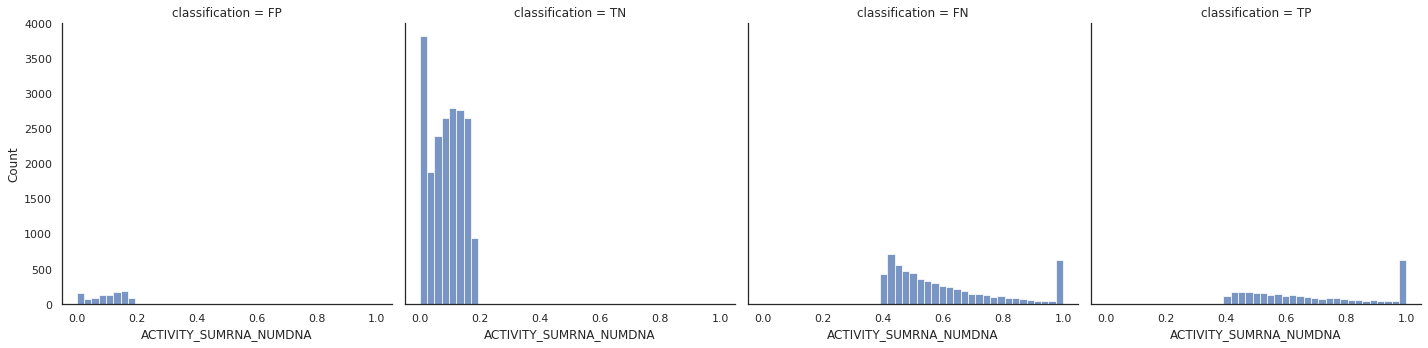

In [101]:
sns.set_style("white")
sns.displot(data=test_df, x="ACTIVITY_SUMRNA_NUMDNA", col="classification", col_order=["FP", "TN", "FN", "TP"])

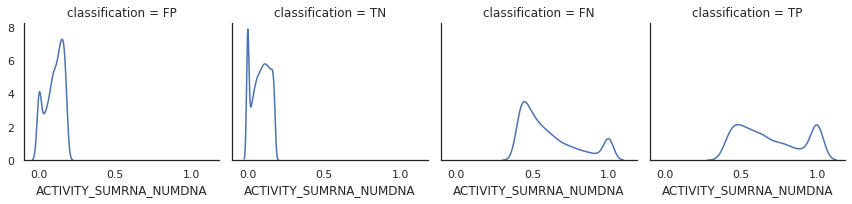

In [104]:
sns.set_style("white")
g = sns.FacetGrid(test_df, col="classification", col_order=["FP", "TN", "FN", "TP"])
g.map(sns.kdeplot, "ACTIVITY_SUMRNA_NUMDNA")

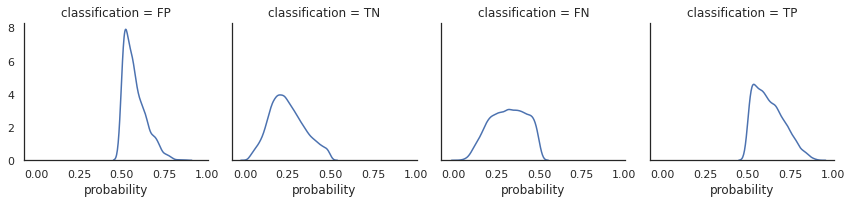

In [105]:
sns.set_style("white")
g = sns.FacetGrid(test_df, col="classification", col_order=["FP", "TN", "FN", "TP"])
g.map(sns.kdeplot, "probability")

In [ ]:
g = sns.FacetGrid(tips, col="time",  row="sex")
g.map(sns.scatterplot, "total_bill", "tip")

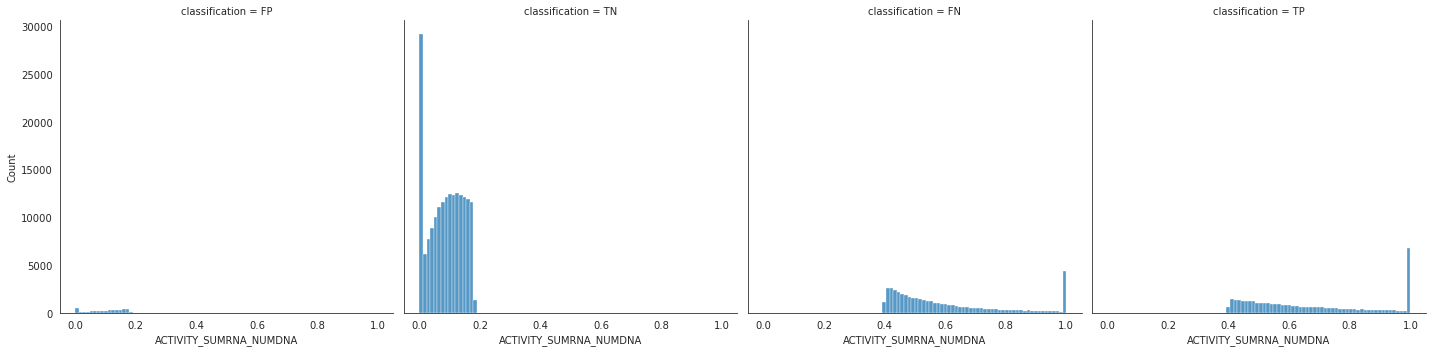

In [44]:
sns.set_style("white")
sns.displot(data=train_df, x="ACTIVITY_SUMRNA_NUMDNA", col="classification", col_order=["FP", "TN", "FN", "TP"])